## Chapter 11. 심층 신경망 훈련하기

### 기본 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### 1. 그레이디언트 소실, 그레이디언트 폭주 문제
- 깊은 심층 신경망을 훈련해야 할 때, 심층 신경망을 훈련하다 마주할 수 있다.
- 심층 신경망의 아래쪽으로 갈수록 그레이디언트가 점ㅁ점 더 작아지거나 커지는 현상이다.
- 두 현상 모두  하위층을 훈련하기 매우 어렵게 만든다.

In [2]:
# 로지스틱 활성화 함수
def logit(z):
    return 1 / (1 + np.exp(-z))

그림 저장: sigmoid_saturation_plot


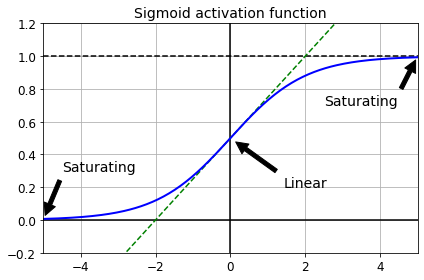

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

- 글로럿 초기화(세이비어 초기화) : 활성화 함수 없음, 하이퍼볼릭 탄젠트, 로지스틱, 소프트 맥스 / 정규분포 : 1/fan_avg
- He 초기화 : ReLU 함수와 그 변종들을 활성화 함수로 사용 / 정규분포 : 2/fan_in
- 르쿤 초기화 : SELU 활성화 함수 사용 / 정규분포 : 1/fan_in

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [5]:
# 케라스는 기본적으로 균등본포의 글로럿 초기화를 사용하지만 아래 처럼 옵션을 바꾸어 he 초기화도 사용할 수 있다.
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
# fan_in 대신 fan_avg 기반의 균등분포 He 초기화 사용하기
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

#### 수렴하지 않는 활성화 함수
- 활성화 함수를 잘못 선택하면 자칫 그레이디언트의 소실이나 폭주로 이어질 수 있다.
- 시그모이드 대안으로 ReLU가 나왔지만 이 역시 완벽하지 않다.(dying ReLU)

- 해결하기 위해 등장한 LeakyReLU, RReLU, PReLU ...
- ELU : 다른 모든 ReLU 변종의 성능을 앞지르고 훈련시간이 줄고 신경망의 테스트 세트 성능도 더 높음

In [7]:
# leaky ReLU
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

그림 저장: leaky_relu_plot


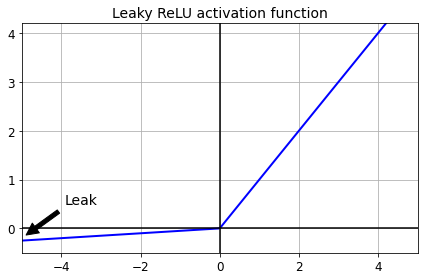

In [8]:
# 시각화
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [11]:
# LeakyReLU를 사용해 패션 MNIST에서 신경망을 훈련
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0 # normalize
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

# 모델 생성
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

2022-09-26 13:47:22.782846: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-26 13:47:22.784322: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [13]:
# 모델 컴파일
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [14]:
# 모델 훈련
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 111us/sample - loss: 1.2806 - accuracy: 0.6250 - val_loss: 0.8883 - val_accuracy: 0.7152
Epoch 2/10
55000/55000 [==============================] - 6s 101us/sample - loss: 0.7954 - accuracy: 0.7373 - val_loss: 0.7135 - val_accuracy: 0.7648
Epoch 3/10
55000/55000 [==============================] - 6s 102us/sample - loss: 0.6816 - accuracy: 0.7727 - val_loss: 0.6356 - val_accuracy: 0.7882
Epoch 4/10
55000/55000 [==============================] - 6s 101us/sample - loss: 0.6215 - accuracy: 0.7936 - val_loss: 0.5922 - val_accuracy: 0.8006
Epoch 5/10
55000/55000 [==============================] - 5s 99us/sample - loss: 0.5830 - accuracy: 0.8081 - val_loss: 0.5596 - val_accuracy: 0.8172
Epoch 6/10
55000/55000 [==============================] - 5s 99us/sample - loss: 0.5553 - accuracy: 0.8155 - val_loss: 0.5338 - val_accuracy: 0.8238
Epoch 7/10
55000/55000 [=============================

In [15]:
# PReLU test
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(), # LeakyReLU 에서 PReLU로 변경
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 136us/sample - loss: 1.3470 - accuracy: 0.6225 - val_loss: 0.9268 - val_accuracy: 0.7200
Epoch 2/10
55000/55000 [==============================] - 7s 120us/sample - loss: 0.8208 - accuracy: 0.7357 - val_loss: 0.7322 - val_accuracy: 0.7640
Epoch 3/10
55000/55000 [==============================] - 7s 120us/sample - loss: 0.6972 - accuracy: 0.7697 - val_loss: 0.6494 - val_accuracy: 0.7868
Epoch 4/10
55000/55000 [==============================] - 7s 127us/sample - loss: 0.6332 - accuracy: 0.7903 - val_loss: 0.6027 - val_accuracy: 0.8026
Epoch 5/10
55000/55000 [==============================] - 8s 151us/sample - loss: 0.5918 - accuracy: 0.8050 - val_loss: 0.5675 - val_accuracy: 0.8140
Epoch 6/10
55000/55000 [==============================] - 7s 123us/sample - loss: 0.5619 - accuracy: 0.8140 - val_loss: 0.5393 - val_accuracy: 0.8250
Epoch 7/10
55000/55000 [===========================

In [18]:
# ELU 
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

그림 저장: elu_plot


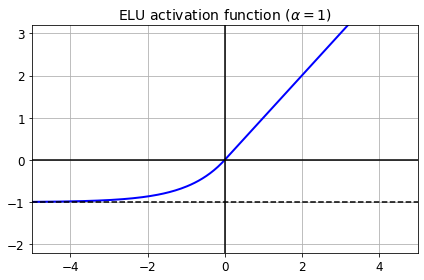

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

In [20]:
# 텐서플로에서 쉽게 ELU 적용 가능, 층을 만들 때 활성화 함수로 지정하면 됨.
keras.layers.Dense(10, activation="elu")

- ELU는 지수함수를 사용해서 다른 ReLU 함수들보다 계산이 느리다. 수렴 속도가 빨라서 어느정도 느린 계산 상쇄가 가능하지만 테스트 시에는 느려짐

#### SELU : ELU 변종, 자기 정규화를 할 수 있다. 
- 자기 정규화가 일어나는 조건을 만족할 수 있다면 SELU를 사용하는 것은 특히 아주 깊은 네트워크에서 뛰어난 성능을 보인다.

- 훈련하는 동안 완전 연결 층만 쌓아서 신경망을 만들고 SELU 활성화 함수와 LeCun 초기화를 사용한다면 자기 정규화
- 각 층의 출력이 평균과 표준편차를 보존하는 경향, 이는 그레이디언트 소실과 폭주 문제를 막아줍니다. 
- SELU 활성화 함수의 자기 정규화 특징은 쉽게 깨집니다. ℓ1나 ℓ2 정규화, 드롭아웃, 맥스 노름, 스킵 연결이나 시퀀셜하지 않은 다른 토폴로지를 사용할 수 없습니다(즉 순환 신경망은 자기 정규화되지 않습니다).
- 하지만 실전에서 시퀀셜 CNN과 잘 동작합니다. 자기 정규화가 깨지면 SELU가 다른 활성화 함수보다 더 나은 성능을 내지 않을 것입니다.

In [21]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [22]:
# SELU
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

그림 저장: selu_plot


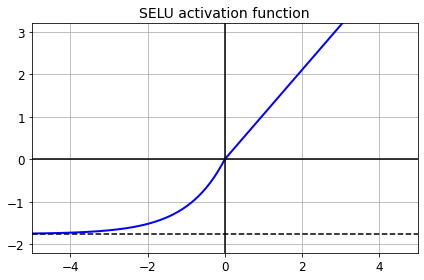

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

- 기본적으로 SELU 하이퍼파라미터(scale과 alpha)는 각 뉴런의 평균 출력이 0에 가깝고 표준 편차는 1에 가깝도록 조정된다.(입력은 평균이 0이고 표준 편차 1로 표준화되었다고 가정)
- 이 활성화 함수를 사용하면 1,000개의 층이 있는 심층 신경망도 모든 층에 걸쳐 거의 평균이 0이고 표준 편차를 1로 유지
- 이를 통해 그레이디언트 폭주와 소실 문제를 피할 수 있음

In [24]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.82
Layer 900: mean 0.02, std deviation 1.00


In [25]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

In [26]:
# 100개의 은닉층, SELU 활성화 함수를 사용한 패션 MNIST를 위한 신경망
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [29]:
# 입력이 평균이 0이되고 표준편차가 1이 되도록 만들어야 함.

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [30]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 302s 5ms/sample - loss: 1.4436 - accuracy: 0.4205 - val_loss: 1.0135 - val_accuracy: 0.6116
Epoch 2/5
55000/55000 [==============================] - 205s 4ms/sample - loss: 0.9605 - accuracy: 0.6321 - val_loss: 0.8413 - val_accuracy: 0.6718
Epoch 3/5
55000/55000 [==============================] - 387s 7ms/sample - loss: 0.7565 - accuracy: 0.7114 - val_loss: 0.6875 - val_accuracy: 0.7470
Epoch 4/5
55000/55000 [==============================] - 302s 5ms/sample - loss: 0.8858 - accuracy: 0.6616 - val_loss: 0.8381 - val_accuracy: 0.6902
Epoch 5/5
55000/55000 [==============================] - 255s 5ms/sample - loss: 0.6956 - accuracy: 0.7474 - val_loss: 0.6321 - val_accuracy: 0.7666


In [37]:
# SELU 대신 ReLU 활성화 함수를 사용하여 훈련시키기
np.random.seed(42)
tf.random.set_seed(42)

In [38]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 108s 2ms/sample - loss: 1.8072 - accuracy: 0.2775 - val_loss: 1.2367 - val_accuracy: 0.4794
Epoch 2/5
55000/55000 [==============================] - 102s 2ms/sample - loss: 1.0917 - accuracy: 0.5502 - val_loss: 1.0283 - val_accuracy: 0.5816
Epoch 3/5
55000/55000 [==============================] - 102s 2ms/sample - loss: 1.0298 - accuracy: 0.5838 - val_loss: 0.8512 - val_accuracy: 0.6574
Epoch 4/5
55000/55000 [==============================] - 101s 2ms/sample - loss: 0.9445 - accuracy: 0.6129 - val_loss: 0.7597 - val_accuracy: 0.7016
Epoch 5/5
55000/55000 [==============================] - 101s 2ms/sample - loss: 0.7935 - accuracy: 0.6958 - val_loss: 0.7308 - val_accuracy: 0.7112


#### 배치 정규화
- 입력을 원점에 맞추고 정규화한 다음, 각 층에서 두 개의 새로운 파라미터로 결과값의 스케일 조정하고 이동
- 그레이디언트 소실과 폭주 문제를 해결하기 위한 다른 대안

In [41]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [42]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_313 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_314 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_315 (Dense)            (None, 10)               

In [43]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [44]:
# updates 속성은 향후 삭제될 예정입니다.
# bn1.updates

In [45]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [46]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 13s 232us/sample - loss: 0.8767 - accuracy: 0.7137 - val_loss: 0.5532 - val_accuracy: 0.8208
Epoch 2/10
55000/55000 [==============================] - 12s 219us/sample - loss: 0.5755 - accuracy: 0.8018 - val_loss: 0.4758 - val_accuracy: 0.8456
Epoch 3/10
55000/55000 [==============================] - 12s 215us/sample - loss: 0.5154 - accuracy: 0.8210 - val_loss: 0.4395 - val_accuracy: 0.8542
Epoch 4/10
55000/55000 [==============================] - 12s 214us/sample - loss: 0.4842 - accuracy: 0.8312 - val_loss: 0.4161 - val_accuracy: 0.8592
Epoch 5/10
55000/55000 [==============================] - 12s 216us/sample - loss: 0.4561 - accuracy: 0.8425 - val_loss: 0.4003 - val_accuracy: 0.8650
Epoch 6/10
55000/55000 [==============================] - 12s 218us/sample - loss: 0.4400 - accuracy: 0.8468 - val_loss: 0.3883 - val_accuracy: 0.8696
Epoch 7/10
55000/55000 [=====================

In [47]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [48]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [49]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 12s 226us/sample - loss: 1.0323 - accuracy: 0.6754 - val_loss: 0.6734 - val_accuracy: 0.7840
Epoch 2/10
55000/55000 [==============================] - 12s 213us/sample - loss: 0.6778 - accuracy: 0.7815 - val_loss: 0.5572 - val_accuracy: 0.8198
Epoch 3/10
55000/55000 [==============================] - 14s 260us/sample - loss: 0.5923 - accuracy: 0.8050 - val_loss: 0.5003 - val_accuracy: 0.8344
Epoch 4/10
55000/55000 [==============================] - 12s 212us/sample - loss: 0.5449 - accuracy: 0.8168 - val_loss: 0.4668 - val_accuracy: 0.8432
Epoch 5/10
55000/55000 [==============================] - 12s 215us/sample - loss: 0.5117 - accuracy: 0.8268 - val_loss: 0.4431 - val_accuracy: 0.8514
Epoch 6/10
55000/55000 [==============================] - 16s 283us/sample - loss: 0.4886 - accuracy: 0.8353 - val_loss: 0.4277 - val_accuracy: 0.8542
Epoch 7/10
55000/55000 [=====================

In [50]:
# 그레이디언트 클리핑
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [51]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

### 2. 사전훈련된 층 재사용하기

In [52]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [53]:
X_train_A.shape

(43986, 28, 28)

In [54]:
X_train_B.shape

(200, 28, 28)

In [55]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [56]:
y_train_B[:30] # 30개 추출

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [57]:
tf.random.set_seed(42)
np.random.seed(42)

In [58]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [59]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [60]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/20
43986/43986 [==============================] - 11s 250us/sample - loss: 0.5909 - accuracy: 0.8099 - val_loss: 0.3772 - val_accuracy: 0.8707
Epoch 2/20
43986/43986 [==============================] - 10s 227us/sample - loss: 0.3521 - accuracy: 0.8792 - val_loss: 0.3394 - val_accuracy: 0.8779
Epoch 3/20
43986/43986 [==============================] - 10s 228us/sample - loss: 0.3167 - accuracy: 0.8891 - val_loss: 0.3017 - val_accuracy: 0.8959
Epoch 4/20
43986/43986 [==============================] - 10s 226us/sample - loss: 0.2970 - accuracy: 0.8968 - val_loss: 0.2857 - val_accuracy: 0.9033
Epoch 5/20
43986/43986 [==============================] - 10s 230us/sample - loss: 0.2824 - accuracy: 0.9031 - val_loss: 0.2806 - val_accuracy: 0.9066
Epoch 6/20
43986/43986 [==============================] - 10s 235us/sample - loss: 0.2721 - accuracy: 0.9072 - val_loss: 0.2683 - val_accuracy: 0.9106
Epoch 7/20
43986/43986 [=====================

In [61]:
model_A.save("my_model_A.h5") # 모델 저장

In [62]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [63]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [64]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/20
200/200 [==============================] - 1s 4ms/sample - loss: 0.9545 - accuracy: 0.4600 - val_loss: 0.6655 - val_accuracy: 0.5385
Epoch 2/20
200/200 [==============================] - 0s 968us/sample - loss: 0.5899 - accuracy: 0.6900 - val_loss: 0.4785 - val_accuracy: 0.8519
Epoch 3/20
200/200 [==============================] - 0s 1ms/sample - loss: 0.4512 - accuracy: 0.8800 - val_loss: 0.4098 - val_accuracy: 0.8945
Epoch 4/20
200/200 [==============================] - 0s 919us/sample - loss: 0.3871 - accuracy: 0.9100 - val_loss: 0.3666 - val_accuracy: 0.9128
Epoch 5/20
200/200 [==============================] - 0s 896us/sample - loss: 0.3438 - accuracy: 0.9250 - val_loss: 0.3315 - val_accuracy: 0.9300
Epoch 6/20
200/200 [==============================] - 0s 1ms/sample - loss: 0.3095 - accuracy: 0.9300 - val_loss: 0.3034 - val_accuracy: 0.9402
Epoch 7/20
200/200 [==============================] - 0s 938us/sample - loss: 0.2810

In [65]:
model_B.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_325 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_326 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_327 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_328 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_329 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_330 (Dense)            (None, 1)                

In [66]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [67]:

model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [68]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [69]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 1s 4ms/sample - loss: 0.2790 - accuracy: 0.9250 - val_loss: 0.2926 - val_accuracy: 0.9219
Epoch 2/4
200/200 [==============================] - 0s 1ms/sample - loss: 0.2681 - accuracy: 0.9300 - val_loss: 0.2823 - val_accuracy: 0.9290
Epoch 3/4
200/200 [==============================] - 0s 894us/sample - loss: 0.2581 - accuracy: 0.9350 - val_loss: 0.2729 - val_accuracy: 0.9320
Epoch 4/4
200/200 [==============================] - 0s 908us/sample - loss: 0.2489 - accuracy: 0.9400 - val_loss: 0.2643 - val_accuracy: 0.9341
Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 1s 4ms/sample - loss: 0.2227 - accuracy: 0.9450 - val_loss: 0.2118 - val_accuracy: 0.9604
Epoch 2/16
200/200 [==============================] - 0s 1ms/sample - loss: 0.1759 - accuracy: 0.9550 - val_loss: 0.1773 - val_accuracy: 0.9736
Epoch 3/16
200/200 [========================

In [70]:
model_B.evaluate(X_test_B, y_test_B)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.14446661782264708, 0.9695]

In [71]:
model_B_on_A.evaluate(X_test_B, y_test_B)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.056534422993659975, 0.994]

In [ ]:
#(100 - 97.05) / (100 - 99.40) 숫자는 결과 바탕으로 넣음

### 3. 고속 옵티마이저
- 표준적인 경사하강법 옵티마이저 대신 더 빠른 옵티마이저를 사용할 수 있다.

In [73]:
# 모멘텀 옵티마이저
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [74]:
# 네스테로프 가속 경사
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

In [75]:
# AdaGrad
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

In [76]:
# RMSProp
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [77]:
# Adam 옵티마이저
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [78]:
# Adamax 옵티마이저
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [79]:
# Nadam 옵티마이저
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

#### 학습률 스케쥴링
- 큰 학습률로 시작하고 학습 속도가 느려질 때 학습률을 낮추면 최적의 고정 학습률보다 좋은 솔루션을 더 빨리 발견할 수 있다.

In [80]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [81]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [82]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 8s 152us/sample - loss: 0.4896 - accuracy: 0.8277 - val_loss: 0.4100 - val_accuracy: 0.8588
Epoch 2/25
55000/55000 [==============================] - 8s 152us/sample - loss: 0.3799 - accuracy: 0.8657 - val_loss: 0.3946 - val_accuracy: 0.8616
Epoch 3/25
55000/55000 [==============================] - 8s 151us/sample - loss: 0.3472 - accuracy: 0.8761 - val_loss: 0.3676 - val_accuracy: 0.8720
Epoch 4/25
55000/55000 [==============================] - 9s 166us/sample - loss: 0.3261 - accuracy: 0.8838 - val_loss: 0.3547 - val_accuracy: 0.8744
Epoch 5/25
55000/55000 [==============================] - 10s 174us/sample - loss: 0.3109 - accuracy: 0.8892 - val_loss: 0.3468 - val_accuracy: 0.8762
Epoch 6/25
55000/55000 [==============================] - 10s 173us/sample - loss: 0.2976 - accuracy: 0.8944 - val_loss: 0.3450 - val_accuracy: 0.8800
Epoch 7/25
55000/55000 [=========================

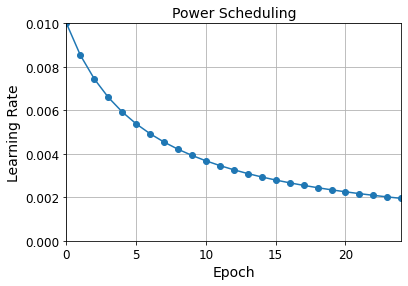

In [83]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [84]:
# 지수 기반 스케쥴링
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [85]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [86]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [87]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 14s 260us/sample - loss: 0.8595 - accuracy: 0.7516 - val_loss: 0.8112 - val_accuracy: 0.7548
Epoch 2/25
55000/55000 [==============================] - 13s 245us/sample - loss: 0.6696 - accuracy: 0.7981 - val_loss: 0.6355 - val_accuracy: 0.8074
Epoch 3/25
55000/55000 [==============================] - 13s 244us/sample - loss: 0.6178 - accuracy: 0.8099 - val_loss: 1.0080 - val_accuracy: 0.7222
Epoch 4/25
55000/55000 [==============================] - 14s 248us/sample - loss: 0.6393 - accuracy: 0.8045 - val_loss: 0.6083 - val_accuracy: 0.8302
Epoch 5/25
55000/55000 [==============================] - 13s 244us/sample - loss: 0.5261 - accuracy: 0.8415 - val_loss: 0.5259 - val_accuracy: 0.8472
Epoch 6/25
55000/55000 [==============================] - 14s 263us/sample - loss: 0.4887 - accuracy: 0.8526 - val_loss: 0.5739 - val_accuracy: 0.8382
Epoch 7/25
55000/55000 [=====================

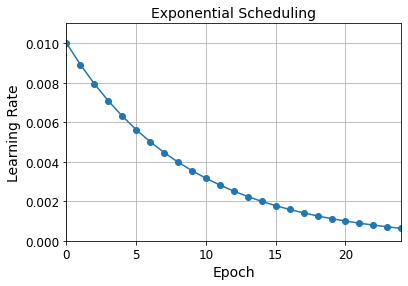

In [88]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [89]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

In [90]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # 노트: 에포크마다 `batch` 매개변수가 재설정됩니다
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # 20 에포크 동안 스텝 횟수 (배치 크기 = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 14s 255us/sample - loss: 0.7893 - accuracy: 0.7654 - val_loss: 0.6612 - val_accuracy: 0.7936
Epoch 2/25
55000/55000 [==============================] - 13s 236us/sample - loss: 0.6720 - accuracy: 0.7960 - val_loss: 0.8779 - val_accuracy: 0.7184
Epoch 3/25
55000/55000 [==============================] - 13s 237us/sample - loss: 0.6011 - accuracy: 0.8166 - val_loss: 0.5863 - val_accuracy: 0.8374
Epoch 4/25
55000/55000 [==============================] - 13s 237us/sample - loss: 0.5394 - accuracy: 0.8360 - val_loss: 0.4938 - val_accuracy: 0.8508
Epoch 5/25
55000/55000 [==============================] - 13s 237us/sample - loss: 0.4644 - accuracy: 0.8522 - val_loss: 0.5287 - val_accuracy: 0.8528
Epoch 6/25
55000/55000 [==============================] - 13s 236us/sample - loss: 0.4463 - accuracy: 0.8598 - val_loss: 0.5118 - val_accuracy: 0.8622
Epoch 7/25
55000/55000 [=====================

In [91]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

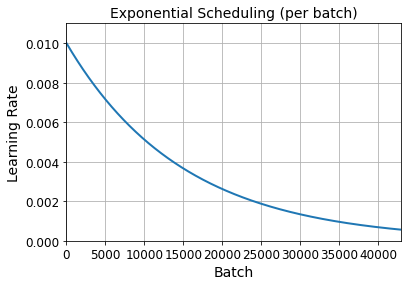

In [92]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

In [93]:
# 기간별 고정 스케쥴링
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [94]:

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [95]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 21s 376us/sample - loss: 0.8709 - accuracy: 0.7519 - val_loss: 0.7753 - val_accuracy: 0.7840
Epoch 2/25
55000/55000 [==============================] - 19s 352us/sample - loss: 0.7689 - accuracy: 0.7738 - val_loss: 0.7329 - val_accuracy: 0.7918
Epoch 3/25
55000/55000 [==============================] - 22s 396us/sample - loss: 0.9029 - accuracy: 0.7331 - val_loss: 0.8444 - val_accuracy: 0.7726
Epoch 4/25
55000/55000 [==============================] - 28s 509us/sample - loss: 0.9264 - accuracy: 0.7211 - val_loss: 1.1337 - val_accuracy: 0.6988
Epoch 5/25
55000/55000 [==============================] - 24s 440us/sample - loss: 0.9926 - accuracy: 0.6692 - val_loss: 1.1884 - val_accuracy: 0.5222
Epoch 6/25
55000/55000 [==============================] - 30s 537us/sample - loss: 0.6960 - accuracy: 0.7640 - val_loss: 0.6512 - val_accuracy: 0.8146
Epoch 7/25
55000/55000 [=====================

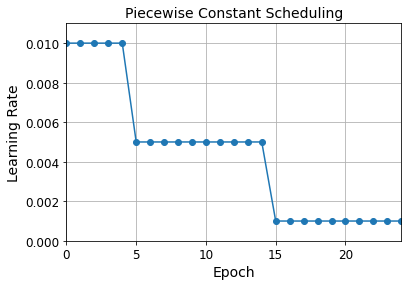

In [96]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [97]:
# 성능 기반 스케쥴링
tf.random.set_seed(42)
np.random.seed(42)

In [98]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 13s 241us/sample - loss: 0.6118 - accuracy: 0.8022 - val_loss: 0.5141 - val_accuracy: 0.8270
Epoch 2/25
55000/55000 [==============================] - 18s 325us/sample - loss: 0.5156 - accuracy: 0.8362 - val_loss: 0.6769 - val_accuracy: 0.8052
Epoch 3/25
55000/55000 [==============================] - 16s 290us/sample - loss: 0.5162 - accuracy: 0.8423 - val_loss: 0.6222 - val_accuracy: 0.8334
Epoch 4/25
55000/55000 [==============================] - 14s 257us/sample - loss: 0.5183 - accuracy: 0.8461 - val_loss: 0.5552 - val_accuracy: 0.8332
Epoch 5/25
55000/55000 [==============================] - 17s 317us/sample - loss: 0.5340 - accuracy: 0.8479 - val_loss: 0.5627 - val_accuracy: 0.8622
Epoch 6/25
55000/55000 [==============================] - 13s 242us/sample - loss: 0.5126 - accuracy: 0.8553 - val_loss: 0.4915 - val_accuracy: 0.8568
Epoch 7/25
55000/55000 [=====================

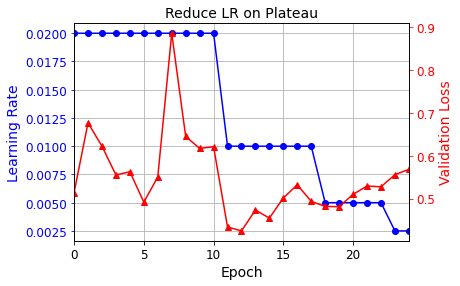

In [99]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

In [100]:
# tf.keras 스케쥴러
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 10s 181us/sample - loss: 0.4888 - accuracy: 0.8271 - val_loss: 0.4077 - val_accuracy: 0.8594
Epoch 2/25
55000/55000 [==============================] - 13s 237us/sample - loss: 0.3819 - accuracy: 0.8654 - val_loss: 0.3886 - val_accuracy: 0.8662
Epoch 3/25
55000/55000 [==============================] - 18s 328us/sample - loss: 0.3479 - accuracy: 0.8765 - val_loss: 0.3673 - val_accuracy: 0.8690
Epoch 4/25
55000/55000 [==============================] - 13s 238us/sample - loss: 0.3264 - accuracy: 0.8838 - val_loss: 0.3515 - val_accuracy: 0.8790
Epoch 5/25
55000/55000 [==============================] - 16s 284us/sample - loss: 0.3100 - accuracy: 0.8897 - val_loss: 0.3428 - val_accuracy: 0.8788
Epoch 6/25
55000/55000 [==============================] - 12s 226us/sample - loss: 0.2960 - accuracy: 0.8947 - val_loss: 0.3402 - val_accuracy: 0.8824
Epoch 7/25
55000/55000 [=====================

In [101]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

In [102]:
# 1사이클 스케쥴링
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [103]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Train on 55000 samples
55000/55000 [==============================] - 6s 102us/sample - loss: nan - accuracy: 0.3960  


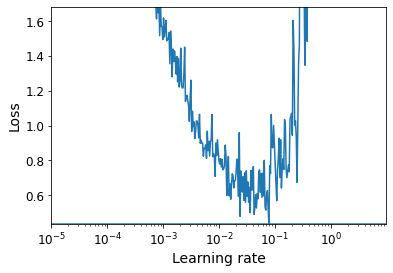

In [104]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [105]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [106]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 89us/sample - loss: 0.6570 - accuracy: 0.7750 - val_loss: 0.4876 - val_accuracy: 0.8298
Epoch 2/25
55000/55000 [==============================] - 5s 85us/sample - loss: 0.4585 - accuracy: 0.8391 - val_loss: 0.4391 - val_accuracy: 0.8480
Epoch 3/25
55000/55000 [==============================] - 5s 83us/sample - loss: 0.4124 - accuracy: 0.8542 - val_loss: 0.4102 - val_accuracy: 0.8574
Epoch 4/25
55000/55000 [==============================] - 5s 86us/sample - loss: 0.3842 - accuracy: 0.8642 - val_loss: 0.3891 - val_accuracy: 0.8654
Epoch 5/25
55000/55000 [==============================] - 5s 84us/sample - loss: 0.3641 - accuracy: 0.8705 - val_loss: 0.3732 - val_accuracy: 0.8690
Epoch 6/25
55000/55000 [==============================] - 5s 85us/sample - loss: 0.3456 - accuracy: 0.8778 - val_loss: 0.3652 - val_accuracy: 0.8722
Epoch 7/25
55000/55000 [==============================] -

### 4. 규제를 사용해 과대적합 피하기

In [107]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [108]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 15s 277us/sample - loss: 1.5895 - accuracy: 0.8103 - val_loss: 0.7553 - val_accuracy: 0.8096
Epoch 2/2
55000/55000 [==============================] - 263s 5ms/sample - loss: 0.7184 - accuracy: 0.8264 - val_loss: 0.7178 - val_accuracy: 0.8222


In [109]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 18s 322us/sample - loss: 1.6418 - accuracy: 0.8107 - val_loss: 0.7600 - val_accuracy: 0.8068
Epoch 2/2
55000/55000 [==============================] - 15s 269us/sample - loss: 0.7197 - accuracy: 0.8262 - val_loss: 0.7175 - val_accuracy: 0.8254


In [110]:
# 드롭아웃
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 19s 347us/sample - loss: 0.5765 - accuracy: 0.8004 - val_loss: 0.3741 - val_accuracy: 0.8642
Epoch 2/2
55000/55000 [==============================] - 18s 332us/sample - loss: 0.4243 - accuracy: 0.8442 - val_loss: 0.3639 - val_accuracy: 0.8612


In [111]:
# 알파드롭아웃
tf.random.set_seed(42)
np.random.seed(42)

In [112]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 14s 253us/sample - loss: 0.6627 - accuracy: 0.7606 - val_loss: 0.5856 - val_accuracy: 0.8400
Epoch 2/20
55000/55000 [==============================] - 14s 262us/sample - loss: 0.5565 - accuracy: 0.7965 - val_loss: 0.5356 - val_accuracy: 0.8464
Epoch 3/20
55000/55000 [==============================] - 24s 433us/sample - loss: 0.5240 - accuracy: 0.8047 - val_loss: 0.5359 - val_accuracy: 0.8500
Epoch 4/20
55000/55000 [==============================] - 22s 404us/sample - loss: 0.5078 - accuracy: 0.8127 - val_loss: 0.4729 - val_accuracy: 0.8636
Epoch 5/20
55000/55000 [==============================] - 19s 340us/sample - loss: 0.4953 - accuracy: 0.8175 - val_loss: 0.4765 - val_accuracy: 0.8590
Epoch 6/20
55000/55000 [==============================] - 17s 305us/sample - loss: 0.4807 - accuracy: 0.8226 - val_loss: 0.4487 - val_accuracy: 0.8644
Epoch 7/20
55000/55000 [=====================

In [113]:
model.evaluate(X_test_scaled, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.46393746762275695, 0.8658]

In [114]:

model.evaluate(X_train_scaled, y_train)

55000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.3406456453865225, 0.88656366]

In [115]:
history = model.fit(X_train_scaled, y_train)

Train on 55000 samples
55000/55000 [==============================] - 13s 242us/sample - loss: 0.4191 - accuracy: 0.8433


In [116]:
# mc드롭아웃
tf.random.set_seed(42)
np.random.seed(42)

In [117]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [118]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [119]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.3 , 0.  , 0.69]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.59, 0.  , 0.  , 0.  , 0.41]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.42, 0.  , 0.55]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.69, 0.  , 0.3 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.04, 0.  , 0.91]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.86]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.78, 0.  , 0.01, 0.  , 0.21]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.1 , 0.  , 0.77]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.07, 0.  , 0.87]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.13, 0.  , 0.72]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.54, 0.  , 0

In [120]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.15, 0.  , 0.72]],
      dtype=float32)

In [121]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.22, 0.  , 0.19, 0.  , 0.26]],
      dtype=float32)

In [122]:
y_pred = np.argmax(y_proba, axis=1)

In [123]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8662

In [124]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [125]:
tf.random.set_seed(42)
np.random.seed(42)

In [126]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [127]:
mc_model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_364 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_365 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_366 (Dense)            (None, 10)              

In [128]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [129]:
mc_model.set_weights(model.get_weights())

In [130]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.16, 0.  , 0.73]],
      dtype=float32)

In [131]:
# 맥스 norm
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [132]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 19s 340us/sample - loss: 0.4762 - accuracy: 0.8331 - val_loss: 0.3799 - val_accuracy: 0.8612
Epoch 2/2
55000/55000 [==============================] - 17s 311us/sample - loss: 0.3585 - accuracy: 0.8683 - val_loss: 0.3505 - val_accuracy: 0.8708
